In [1]:
# Using ResNet-18 for image classification
# Data:
    # cinic10 --> https://www.kaggle.com/mengcius/cinic10
    # a subset of cinic10 containing only four classes - airplane, automobile, ship, and truck - is used
        # files from cinic10 'train' and 'val' folders are combined into one to provide 18000 training images from each class
        # test folders contain 9000 images from each class
        
# Note: here GPU processing is used --> running times with CPU would be greater

In [2]:
# import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import seaborn as sns  # for heatmaps
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style = "whitegrid", font_scale = 1.2)

# ignore non-critical warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# define transforms

cinic_mean = [0.4789, 0.4723, 0.4305] # from cinic10 'Readme' file
cinic_std = [0.2421, 0.2383, 0.2587] # from cinic10 'Readme' file

# we are using the same transforms for both train and test images
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = cinic_mean, std = cinic_std)
])

In [4]:
# prepare train and test sets, loaders

# define root directory path
root = 'datasets/cinic10_classes4'

# batch size
b_size = 16

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform = img_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform = img_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = b_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = b_size, shuffle = True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['airplane', 'automobile', 'ship', 'truck']
Training images available: 72000
Testing images available:  36000


In [5]:
# display a batch of images --> grab first batch of 16 images from train data

for images,labels in train_loader: 
    break
    
images.shape

torch.Size([16, 3, 32, 32])

In [6]:
# 16 images in one batch, 3 color channels (R-G-B), 32 x 32 pixels

Label: [1 1 1 1 1 3 2 2 1 1 1 1 0 0 3 0]
Class: automobile automobile automobile automobile automobile truck ship ship automobile automobile automobile automobile airplane airplane truck airplane


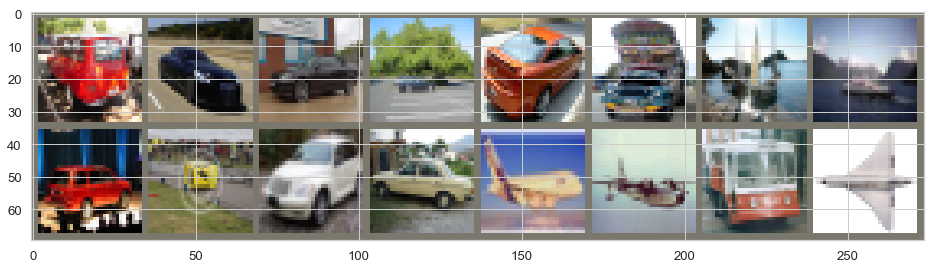

In [7]:
# show images and their classes

# print labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images)  # the default nrow is 8

# inverse normalize the images

inv_normalize = transforms.Normalize(
    mean=[-0.4789/0.2421, -0.4723/0.2383, -0.4305/0.2587],
    std=[1/0.2421, 1/0.2383, 1/0.2587]
)
im_inv = inv_normalize(im)

# print images
plt.figure(figsize=(16,6))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [8]:
# everything works fine!

In [9]:
# select resnet18 model from torchvision models
ResNet18model = models.resnet18()

In [10]:
# display structure of resnet18
ResNet18model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# modify last layer of model to have 4 outputs only --> we work with four classes only
torch.manual_seed(42)

ResNet18model.fc = nn.Sequential(nn.Linear(512, 4), 
                                 nn.LogSoftmax(dim=1))

ResNet18model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# last layer of model has been modified to meet our needs

In [13]:
# count model parameters

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(ResNet18model)

  9408
    64
    64
 36864
    64
    64
 36864
    64
    64
 36864
    64
    64
 36864
    64
    64
 73728
   128
   128
147456
   128
   128
  8192
   128
   128
147456
   128
   128
147456
   128
   128
294912
   256
   256
589824
   256
   256
 32768
   256
   256
589824
   256
   256
589824
   256
   256
1179648
   512
   512
2359296
   512
   512
131072
   512
   512
2359296
   512
   512
2359296
   512
   512
  2048
     4
______
11178564


In [14]:
# approximately 11 million parameters which is not so large of a number

In [15]:
# check if GPU computing is available

# torch.cuda.is_available() checks and returns a Boolean True if a GPU with CUDA is available, else it returns False
is_cuda = torch.cuda.is_available()

# set device to GPU or CPU depending on the outcome --> we will use this device variable later on in our code!
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [16]:
# set model to work with available device
ResNet18model.to(device)

# define optimizer --> optimizer needs to be defined after device for model is selected!
optimizer = torch.optim.Adam(ResNet18model.parameters(), lr = 0.001)

# define loss function
criterion = nn.CrossEntropyLoss()

In [17]:
# start training

import time
start_time = time.time()

epochs = 40

# limit number of train and test images --> optional - saves time to run with small numbers first to see if model works
max_trn_batch = 1000
max_tst_batch = 500

# instantiate trackers for model performance
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # apply the model
        y_pred = ResNet18model(X_train.to(device))
        loss = criterion(y_pred, y_train.to(device))
 
        # tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.to(device)).sum()
        trn_corr += batch_corr
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print interim results
        if b%max_trn_batch == 0:
            print(f'Epoch: {i+1:3}   Batch: {b:4}   Loss: {loss.item():10.4f}   Accuracy: {trn_corr.item()*100/(b_size*b):7.2f}% \
 Time Elapsed Since Start: {(time.time() - start_time)/60:7.2f} min')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # run the test batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # limit the number of batches
            if b == max_tst_batch:
                break

            # apply the model
            y_val = ResNet18model(X_test.to(device))

            # tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test.to(device)).sum()

    loss = criterion(y_val, y_test.to(device))
    test_losses.append(loss)
    test_correct.append(tst_corr)


Epoch:   1   Batch: 1000   Loss:     1.0309   Accuracy:   49.45%  Time Elapsed Since Start:    1.17 min
Epoch:   2   Batch: 1000   Loss:     1.2961   Accuracy:   56.84%  Time Elapsed Since Start:    2.52 min
Epoch:   3   Batch: 1000   Loss:     0.9534   Accuracy:   61.48%  Time Elapsed Since Start:    3.69 min
Epoch:   4   Batch: 1000   Loss:     1.1926   Accuracy:   63.99%  Time Elapsed Since Start:    4.85 min
Epoch:   5   Batch: 1000   Loss:     0.5693   Accuracy:   66.62%  Time Elapsed Since Start:    5.91 min
Epoch:   6   Batch: 1000   Loss:     0.8185   Accuracy:   67.78%  Time Elapsed Since Start:    6.88 min
Epoch:   7   Batch: 1000   Loss:     0.5415   Accuracy:   70.53%  Time Elapsed Since Start:    7.83 min
Epoch:   8   Batch: 1000   Loss:     0.5292   Accuracy:   71.11%  Time Elapsed Since Start:    8.88 min
Epoch:   9   Batch: 1000   Loss:     0.8405   Accuracy:   72.19%  Time Elapsed Since Start:    9.92 min
Epoch:  10   Batch: 1000   Loss:     0.4423   Accuracy:   73.97%

In [18]:
# save the trained model

torch.save(ResNet18model.state_dict(), 'resnet18cinic10cl4.pt')

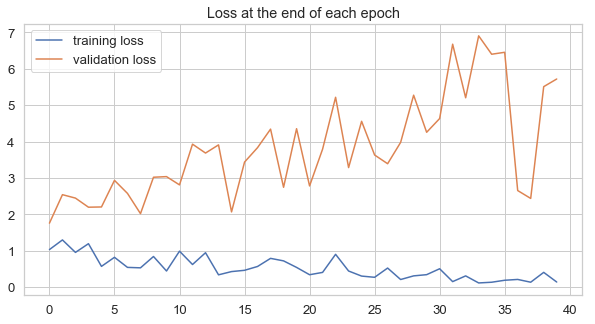

In [19]:
# evaluate model performance

# plot losses
plt.figure(figsize = (10,5))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [20]:
# train and test losses do not converge

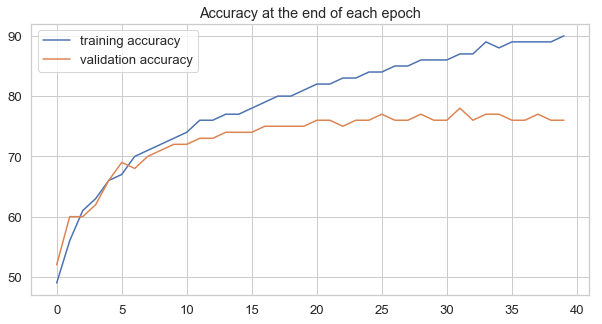

In [21]:
# plot accuracy
plt.figure(figsize = (10,5))
plt.plot([t*100/(max_trn_batch*b_size) for t in train_correct], label='training accuracy')
plt.plot([t*100/(max_tst_batch*b_size) for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [22]:
# accuracy diverges as well
# model achieves 90% training accuracy and ~ 76% testing (validation) accuracy
# after ~ 30 epochs the validation accuracy reaches a plateau, while the training accuracy continues to increase
    # if the number of epochs is increased, model could reach even higher training accuracy by "learning" the training set
    # this, however, will not lead to increase in validation accuracy which is the true model accuracy

In [23]:
# print final test accuracy
print(f'Test accuracy: {test_correct[-1].item()*100/(max_tst_batch*b_size):.2f}%') # take the value after the last epoch

Test accuracy: 76.05%


In [24]:
# test accuracy is 76%

In [25]:
# compare predictions against ground truth
# for better visualization we will use heatmap

In [26]:
# use all test images
test_load_all = DataLoader(test_data, batch_size = 36000, shuffle = False)
print(f'Testing images available:  {len(test_data)}')

Testing images available:  36000


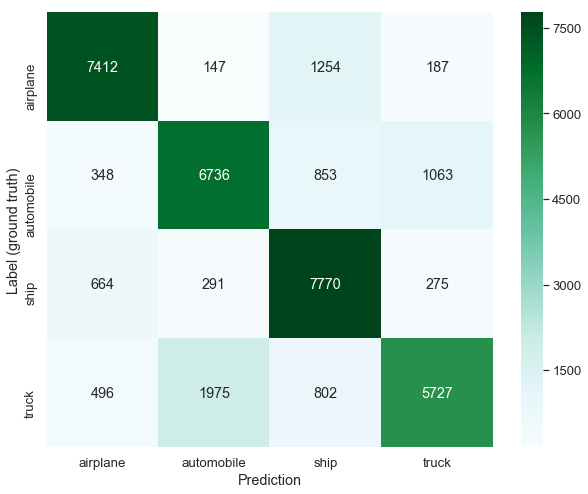

In [27]:
# make predictions with all test images and show confusion matrix results as a heat map

# import confusion matrix
from sklearn.metrics import confusion_matrix

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = ResNet18model(X_test.to(device))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test.to(device)).sum()

# convert results to CPU tensors to be able to use them as numpy arrays!
device = torch.device("cpu")
y_test = y_test.to(device)
predicted = predicted.to(device)

# create heat map from confusion matrix and plot
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot = True, fmt = "d", cmap = 'BuGn')
plt.xlabel("Prediction")
plt.ylabel("Label (ground truth)")
plt.show()

In [28]:
# Confusion matrix shows:
    # class 'ship' has highest prediction accuracy
        # most often mistaken for 'airplane'
    # class 'airplane' has second highest prediction accuracy
        # most often mistaken for 'ship'
    # class 'automobile' is third in prediction accuracy
        # most often mistaken for 'truck'
    # class 'truck' has lowest prediction accuracy
        # most often mistaken for 'automobile'
    # the corresponding classes causing highest confusion are neutral to expect due to the similarities between these classes
    
# In conclusion:
    # overall model test accuracy is 76% which is well above random guess (25%)
    # given the similarity between the objects selected here and the small image resolution we consider this to be good accuracy